In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import networkx as nx
import numpy as np
from random import randint
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_columns', None)

### Pre-Processing

In [4]:
df = pd.read_csv("steam.csv")

In [5]:
df.head(10)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99
6,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action,FPS;Classic;Action,0,27755,1100,1300,83,5000000-10000000,7.19
7,80,Counter-Strike: Condition Zero,2004-03-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Multiplayer,0,12120,1439,427,43,10000000-20000000,7.19
8,130,Half-Life: Blue Shift,2001-06-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player,Action,FPS;Action;Sci-fi,0,3822,420,361,205,5000000-10000000,3.99
9,220,Half-Life 2,2004-11-16,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Action,FPS;Action;Sci-fi,33,67902,2419,691,402,10000000-20000000,7.19


In [6]:
df.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price'],
      dtype='object')

In [7]:
df.shape

(27075, 18)

In [8]:
df.nunique(axis=0)

appid               27075
name                27033
release_date         2619
english                 2
developer           17113
publisher           14354
platforms               7
required_age            6
categories           3333
genres               1552
steamspy_tags        6423
achievements          410
positive_ratings     2800
negative_ratings     1492
average_playtime     1345
median_playtime      1312
owners                 13
price                 282
dtype: int64

In [9]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000
mean,596203.508661,0.981127,0.354903,45.248864,1000.558523,211.027147,149.804949,146.056030,6.078193
std,250894.167246,0.136081,2.406044,352.670281,18988.724439,4284.938531,1827.038141,2353.880080,7.874922
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,401230.000000,1.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,1.690000
50%,599070.000000,1.000000,0.000000,7.000000,24.000000,9.000000,0.000000,0.000000,3.990000
75%,798760.000000,1.000000,0.000000,23.000000,126.000000,42.000000,0.000000,0.000000,7.190000
max,1069460.000000,1.000000,18.000000,9821.000000,2644404.000000,487076.000000,190625.000000,190625.000000,421.990000


In [10]:
df.describe(include='O')

,name,release_date,developer,publisher,platforms,categories,genres,steamspy_tags,owners
count,27075,27075,27075,27075,27075,27075,27075,27075,27075
unique,27033,2619,17113,14354,7,3333,1552,6423,13
top,Dark Matter,2018-07-13,Choice of Games,Big Fish Games,windows,Single-player,Action;Indie,Action;Indie;Casual,0-20000
freq,3,64,94,212,18398,6110,1852,845,18596


In [11]:
df.isnull().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [12]:
df[df.duplicated(keep='first')]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [13]:
df['genres']=df['genres'].str.split(';').fillna(df['genres'])

In [14]:
df = df.explode('genres', ignore_index=True)

In [15]:
df.to_csv("genres.csv")

In [16]:
df.head(50)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99
6,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action,FPS;Classic;Action,0,27755,1100,1300,83,5000000-10000000,7.19
7,80,Counter-Strike: Condition Zero,2004-03-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Multiplayer,0,12120,1439,427,43,10000000-20000000,7.19
8,130,Half-Life: Blue Shift,2001-06-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player,Action,FPS;Action;Sci-fi,0,3822,420,361,205,5000000-10000000,3.99
9,220,Half-Life 2,2004-11-16,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Action,FPS;Action;Sci-fi,33,67902,2419,691,402,10000000-20000000,7.19


### Exploratory Data Analysis

<AxesSubplot:>

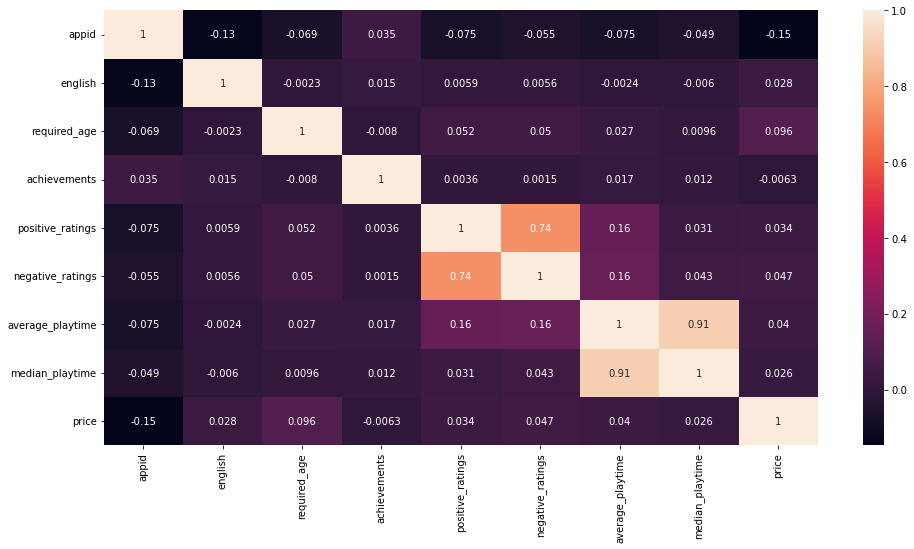

In [17]:
plt.figure(figsize=(16,8))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

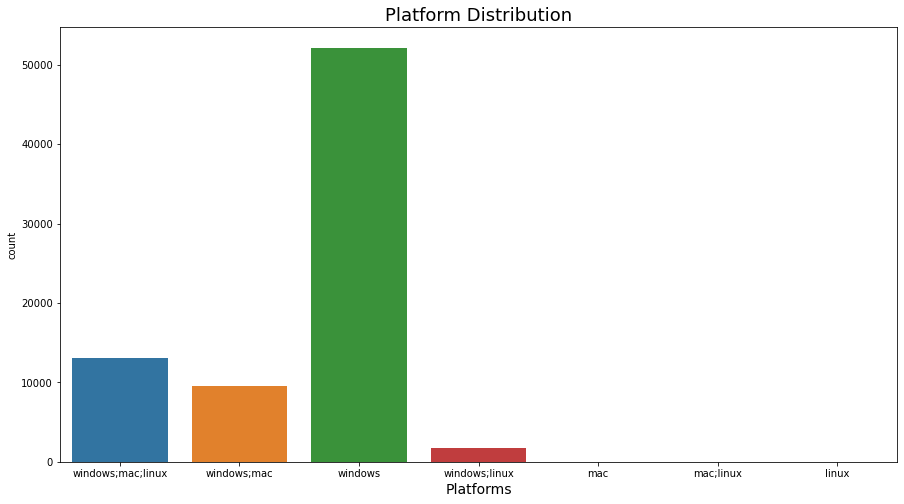

In [18]:
plt.figure(figsize=(15,8))
sns.countplot(x = 'platforms', data = df)
plt.title('Platform Distribution',size=18)
plt.xlabel('Platforms',size=14)
plt.show()

In [19]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_date'].dt.year.value_counts()

2018    24532
2017    18882
2016    12168
2015     7067
2019     6646
2014     3694
2013     1005
2012      708
2011      472
2009      461
2010      395
2008      216
2007      113
2006       63
2005        9
2001        7
2003        7
2004        6
2002        3
1997        3
1999        2
2000        2
1998        1
Name: release_date, dtype: int64

### Bi-Partite Network Creation

In [20]:
S = nx.Graph()
S.add_nodes_from(df['name'], bipartite='Games')
S.add_nodes_from(df['genres'], bipartite='Genres')
S.add_edges_from(
    [(row['genres'], row['name']) for idx, row in df.iterrows()])

In [21]:
nx.write_gexf(S, "steam_bipartite.gexf")

In [22]:
df_genres = pd.read_csv('genres-fixed.csv')
G = nx.from_pandas_edgelist(df_genres,source='Source',target='Target', edge_attr='Weight')

In [23]:
G.number_of_nodes()

29

In [24]:
G.number_of_edges()

277

In [25]:
np.mean([d for _, d in G.degree()])

19.103448275862068

In [26]:
nx.density(G)

0.6822660098522167

In [27]:
nx.number_connected_components(G)

1

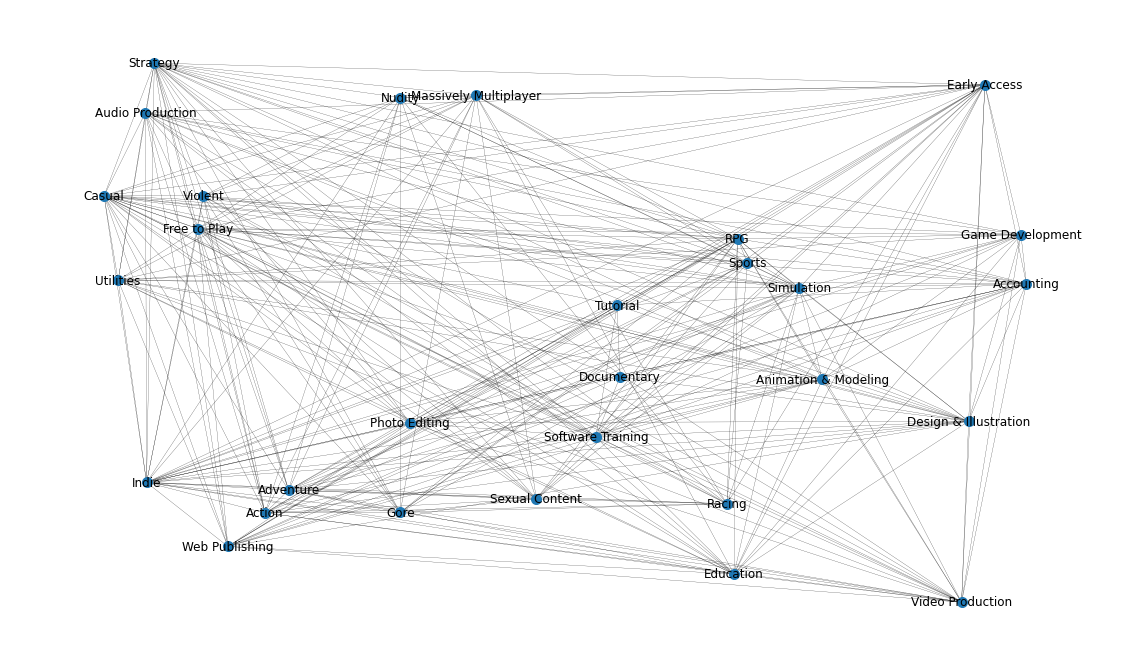

In [28]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.axis("off")
plot_options = {"node_size": 100, "with_labels": True, "width": 0.2}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

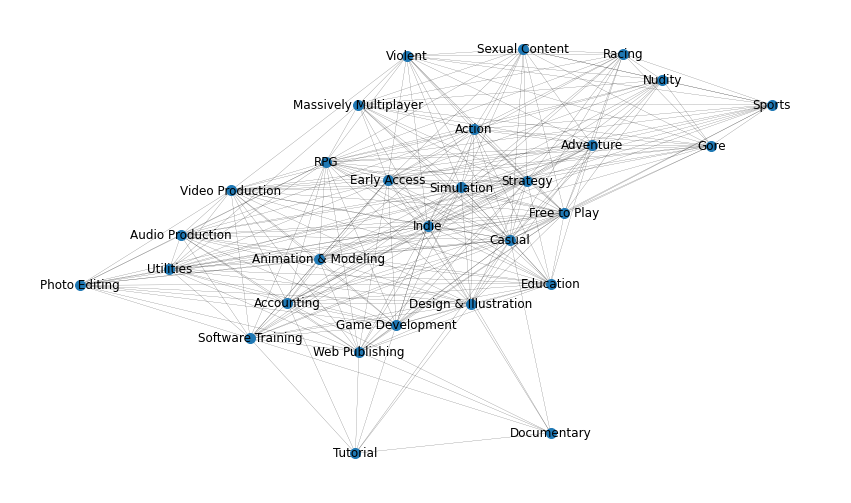

In [29]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 100, "with_labels": True, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Degree Centralities

In [30]:
degree_centrality = nx.centrality.degree_centrality(G)
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))

[('Indie', 1.0),
 ('Casual', 1.0),
 ('Free to Play', 0.9285714285714285),
 ('Strategy', 0.9285714285714285),
 ('RPG', 0.9285714285714285),
 ('Simulation', 0.8928571428571428),
 ('Early Access', 0.8928571428571428),
 ('Video Production', 0.75),
 ('Design & Illustration', 0.75),
 ('Action', 0.7142857142857142),
 ('Adventure', 0.7142857142857142),
 ('Education', 0.7142857142857142),
 ('Accounting', 0.7142857142857142),
 ('Animation & Modeling', 0.6785714285714285),
 ('Web Publishing', 0.6785714285714285),
 ('Software Training', 0.6785714285714285),
 ('Audio Production', 0.6428571428571428),
 ('Utilities', 0.6428571428571428),
 ('Massively Multiplayer', 0.6071428571428571),
 ('Game Development', 0.6071428571428571),
 ('Violent', 0.5714285714285714),
 ('Gore', 0.5714285714285714),
 ('Racing', 0.5357142857142857),
 ('Nudity', 0.5357142857142857),
 ('Sports', 0.5357142857142857),
 ('Sexual Content', 0.5357142857142857),
 ('Photo Editing', 0.5357142857142857),
 ('Documentary', 0.25),
 ('Tutori

In [31]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))

[('Indie', 28),
 ('Casual', 28),
 ('Free to Play', 26),
 ('Strategy', 26),
 ('RPG', 26),
 ('Simulation', 25),
 ('Early Access', 25),
 ('Video Production', 21),
 ('Design & Illustration', 21),
 ('Action', 20),
 ('Adventure', 20),
 ('Education', 20),
 ('Accounting', 20),
 ('Animation & Modeling', 19),
 ('Web Publishing', 19),
 ('Software Training', 19),
 ('Audio Production', 18),
 ('Utilities', 18),
 ('Massively Multiplayer', 17),
 ('Game Development', 17),
 ('Violent', 16),
 ('Gore', 16),
 ('Racing', 15),
 ('Nudity', 15),
 ('Sports', 15),
 ('Sexual Content', 15),
 ('Photo Editing', 15),
 ('Documentary', 7),
 ('Tutorial', 7)]

Text(0, 0.5, 'Counts')

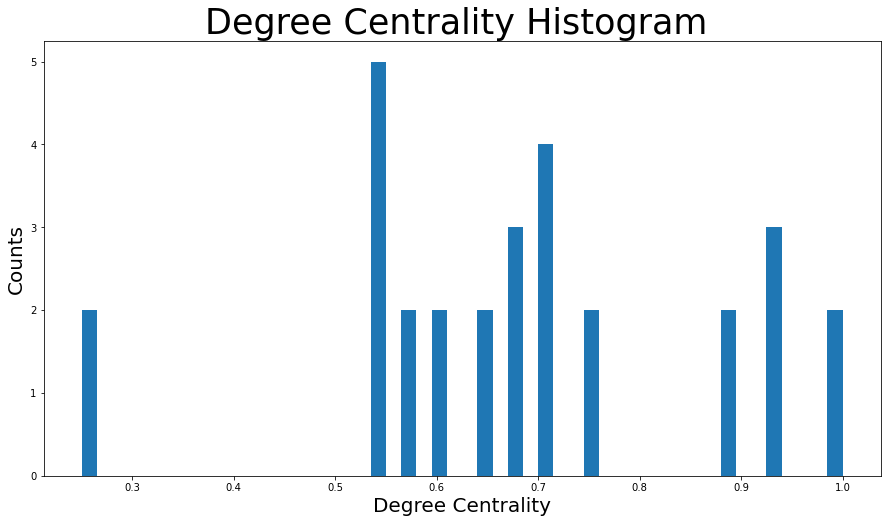

In [32]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=50) # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7021799430283056,
 0.6815284386384335,
 -1.1794586987829287,
 0.8885891633822502)

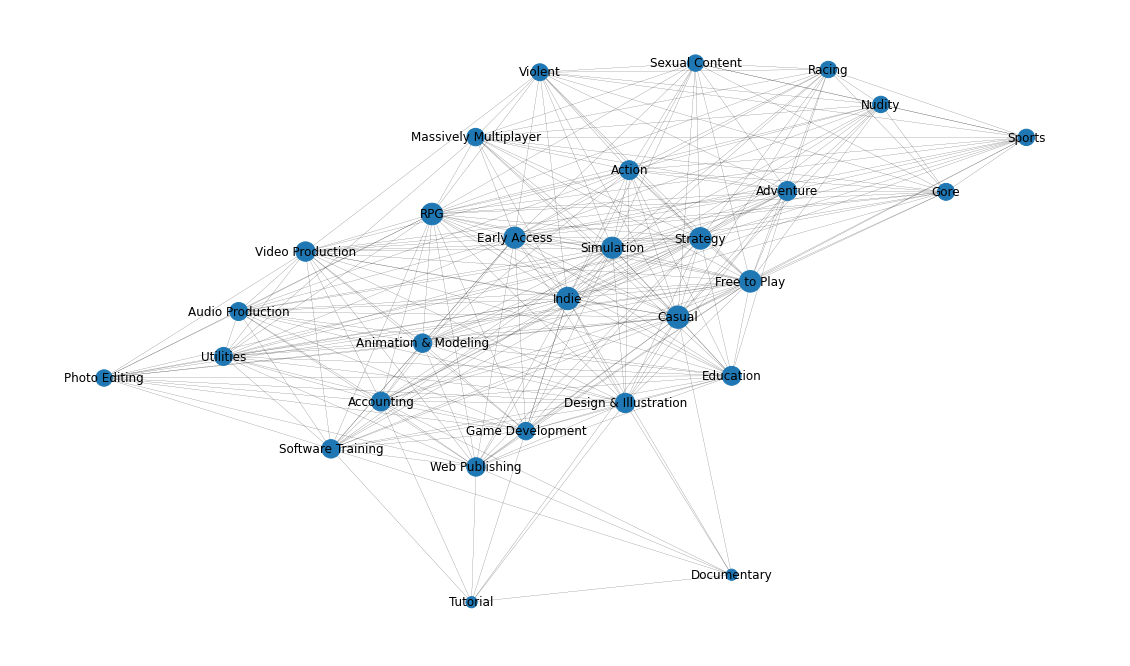

In [33]:
node_size = [
    v * 500 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(20, 12))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=True, width=0.15)
plt.axis("off")

### Betweenness centralities

In [34]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)  
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))


[('Indie', 0.05883929415675448),
 ('Casual', 0.05883929415675448),
 ('Free to Play', 0.026652345303138956),
 ('Strategy', 0.026652345303138956),
 ('RPG', 0.026652345303138956),
 ('Simulation', 0.022394345807044223),
 ('Early Access', 0.022394345807044223),
 ('Design & Illustration', 0.01668701668701669),
 ('Accounting', 0.013590421923755258),
 ('Web Publishing', 0.0109347442680776),
 ('Software Training', 0.0109347442680776),
 ('Video Production', 0.009187417520750855),
 ('Action', 0.008974153418597863),
 ('Adventure', 0.008974153418597863),
 ('Education', 0.005491950730045967),
 ('Massively Multiplayer', 0.0038568427457316345),
 ('Animation & Modeling', 0.0030185863519196854),
 ('Utilities', 0.002826098064193302),
 ('Audio Production', 0.001685660018993352),
 ('Violent', 0.0011655011655011655),
 ('Gore', 0.0011655011655011655),
 ('Game Development', 0.00035273368606701937),
 ('Racing', 0.0),
 ('Nudity', 0.0),
 ('Sports', 0.0),
 ('Sexual Content', 0.0),
 ('Photo Editing', 0.0),
 ('Docu

Text(0, 0.5, 'Counts')

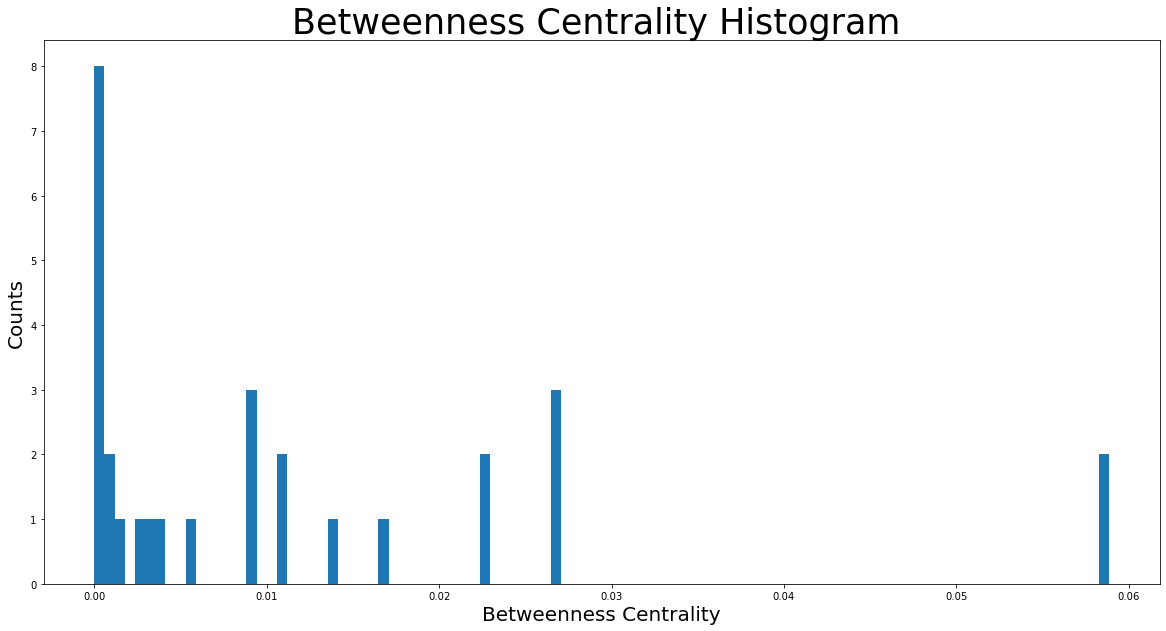

In [35]:
plt.figure(figsize=(20, 10))
plt.hist(betweenness_centrality.values(), bins=100)
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7021799430283056,
 0.6815284386384335,
 -1.1794586987829287,
 0.8885891633822502)

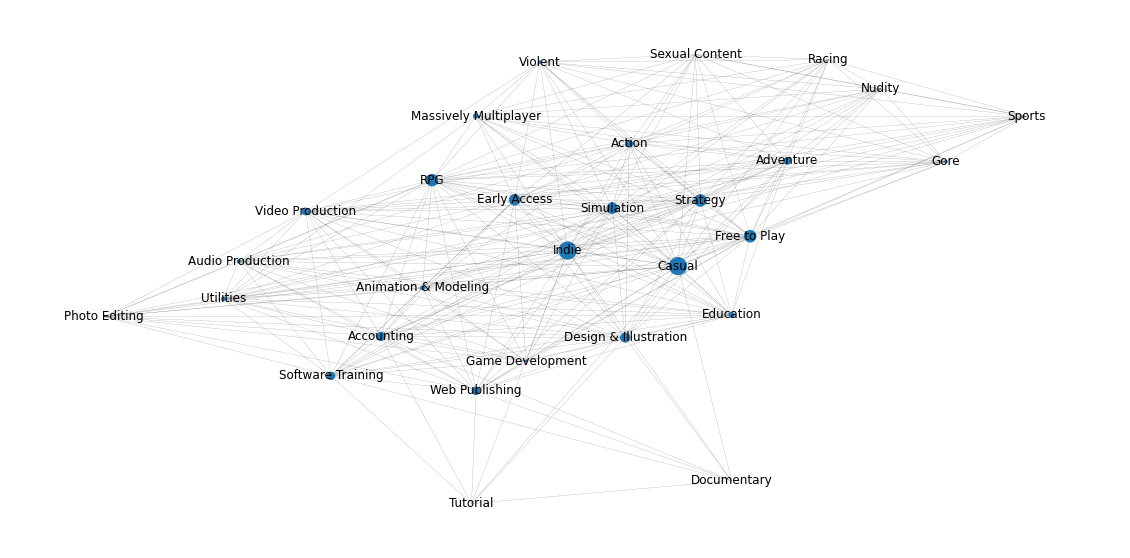

In [36]:
node_size = [
    v * 5000 for v in betweenness_centrality.values()
] 
plt.figure(figsize=(20, 10))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=True, width=0.1)
plt.axis("off")

### Closeness Centralities

In [37]:
closeness_centrality = nx.centrality.closeness_centrality(G)
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))

[('Indie', 1.0),
 ('Casual', 1.0),
 ('Free to Play', 0.9333333333333333),
 ('Strategy', 0.9333333333333333),
 ('RPG', 0.9333333333333333),
 ('Simulation', 0.9032258064516129),
 ('Early Access', 0.9032258064516129),
 ('Video Production', 0.8),
 ('Design & Illustration', 0.8),
 ('Action', 0.7777777777777778),
 ('Adventure', 0.7777777777777778),
 ('Education', 0.7777777777777778),
 ('Accounting', 0.7777777777777778),
 ('Animation & Modeling', 0.7567567567567568),
 ('Web Publishing', 0.7567567567567568),
 ('Software Training', 0.7567567567567568),
 ('Audio Production', 0.7368421052631579),
 ('Utilities', 0.7368421052631579),
 ('Massively Multiplayer', 0.717948717948718),
 ('Game Development', 0.717948717948718),
 ('Violent', 0.7),
 ('Gore', 0.7),
 ('Racing', 0.6829268292682927),
 ('Nudity', 0.6829268292682927),
 ('Sports', 0.6829268292682927),
 ('Sexual Content', 0.6829268292682927),
 ('Photo Editing', 0.6829268292682927),
 ('Documentary', 0.5714285714285714),
 ('Tutorial', 0.5714285714285

Text(0, 0.5, 'Counts')

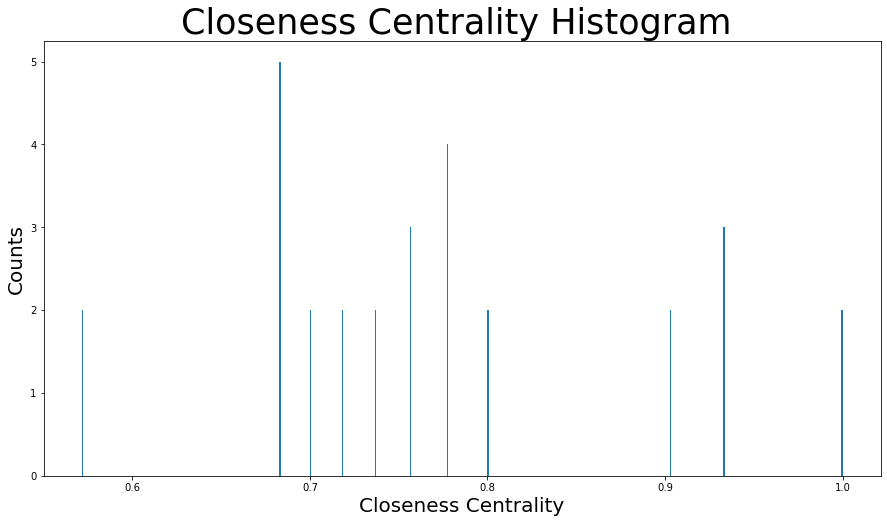

In [38]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=600)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7021799430283056,
 0.6815284386384335,
 -1.1794586987829287,
 0.8885891633822502)

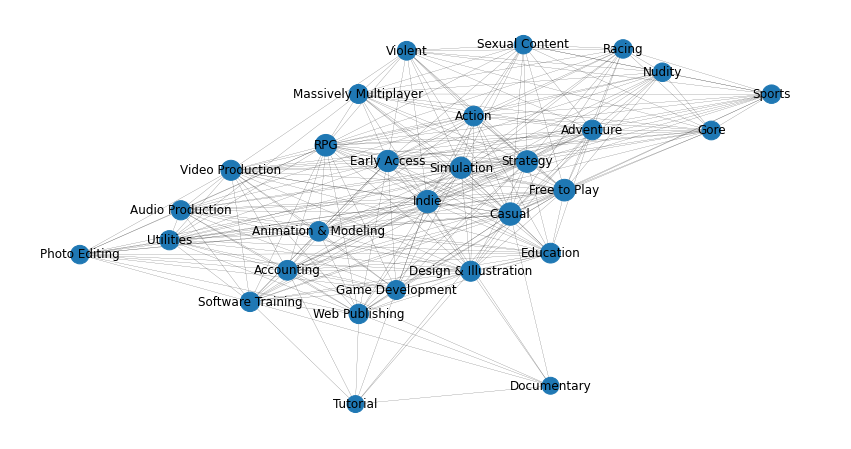

In [39]:
node_size = [
    v * 500 for v in closeness_centrality.values()
] 
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=True, width=0.15)
plt.axis("off")

### Eigenvector Centrality

In [40]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(G, max_iter=1000)  
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))

[('Indie', 0.24389628288626683),
 ('Casual', 0.24389628288626683),
 ('Free to Play', 0.23800650626164152),
 ('Strategy', 0.23800650626164152),
 ('RPG', 0.23800650626164152),
 ('Simulation', 0.23100822748566452),
 ('Early Access', 0.23100822748566452),
 ('Video Production', 0.20347652445663028),
 ('Education', 0.1966660952876991),
 ('Design & Illustration', 0.19499416774340805),
 ('Adventure', 0.18965933585206055),
 ('Action', 0.1893836108325958),
 ('Animation & Modeling', 0.18910439111878274),
 ('Accounting', 0.1861475410802953),
 ('Audio Production', 0.180244884964247),
 ('Utilities', 0.17895996247005055),
 ('Web Publishing', 0.17728803492575956),
 ('Software Training', 0.17728803492575956),
 ('Game Development', 0.17139825830113423),
 ('Massively Multiplayer', 0.16187648624554044),
 ('Violent', 0.15383496040319758),
 ('Gore', 0.15383496040319758),
 ('Photo Editing', 0.1498162475230024),
 ('Racing', 0.1443300554504541),
 ('Nudity', 0.14433005545045408),
 ('Sports', 0.14433005545045408

Text(0, 0.5, 'Counts')

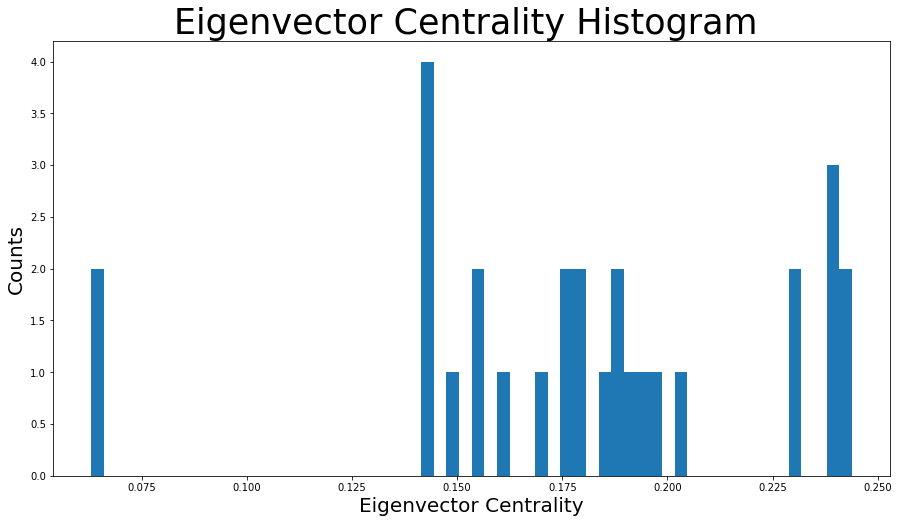

In [41]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7021799430283056,
 0.6815284386384335,
 -1.1794586987829287,
 0.8885891633822502)

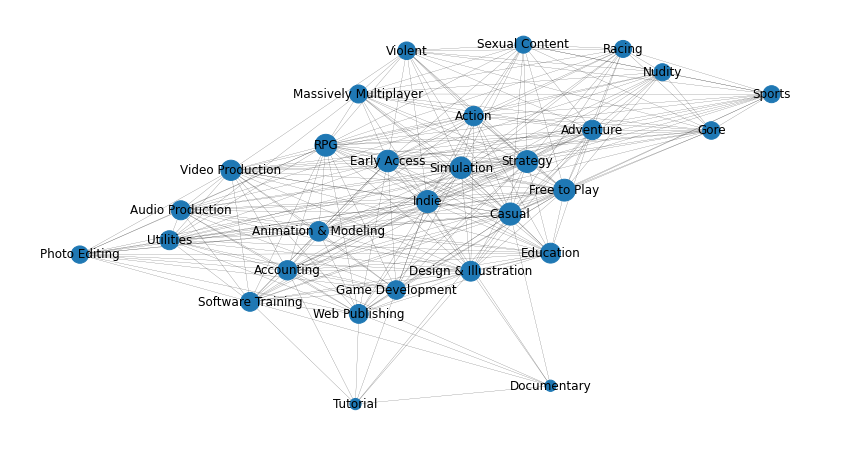

In [42]:
node_size = [
    v * 2000 for v in eigenvector_centrality.values()
] 
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=True, width=0.15)
plt.axis("off")

### Assortavity

In [43]:
nx.degree_assortativity_coefficient(G)

-0.1391628674718925

In [44]:
nx.degree_pearson_correlation_coefficient(G) 

-0.13916286747189277

### Clustering Coefficient

In [45]:
nx.average_clustering(G)

0.8719763873719247

## Genre Evolution

In [46]:
date_range = str(df['release_date'].dt.date.min()) + ' to ' +str(df['release_date'].dt.date.max())
print(date_range)

1997-06-30 to 2019-05-01


In [47]:
### Segregating data into various date ranges
df_95_05 = df[(df['release_date'] >= '1995-1-1') & (df['release_date'] < '2005-1-1')]
df_05 = df[(df['release_date'] >= '2005-1-1') & (df['release_date'] < '2010-1-1')]
df_10 = df[(df['release_date'] >= '2010-1-1') & (df['release_date'] < '2015-1-1')]
df_15 = df[(df['release_date'] >= '2015-1-1') & (df['release_date'] < '2020-1-1')]

#### Converting the dataframes of different times to gexf file for visualization in Gephi

In [48]:
#00'
B = nx.Graph()
B.add_nodes_from(df_95_05['name'], bipartite='Games')
B.add_nodes_from(df_95_05['genres'], bipartite='Genres')
B.add_edges_from(
    [(row['genres'], row['name']) for idx, row in df_95_05.iterrows()])
nx.write_gexf(B, "95_05_steam.gexf")

In [49]:
#05'
C = nx.Graph()
C.add_nodes_from(df_05['name'], bipartite='Games')
C.add_nodes_from(df_05['genres'], bipartite='Genres')
C.add_edges_from(
    [(row['genres'], row['name']) for idx, row in df_05.iterrows()])
nx.write_gexf(C, "05_steam.gexf")

In [50]:
#10'
D = nx.Graph()
D.add_nodes_from(df_10['name'], bipartite='Games')
D.add_nodes_from(df_10['genres'], bipartite='Genres')
D.add_edges_from(
    [(row['genres'], row['name']) for idx, row in df_10.iterrows()])
nx.write_gexf(D, "10_steam.gexf")

In [51]:
#15'
E = nx.Graph()
E.add_nodes_from(df_15['name'], bipartite='Games')
E.add_nodes_from(df_15['genres'], bipartite='Genres')
E.add_edges_from(
    [(row['genres'], row['name']) for idx, row in df_15.iterrows()])
nx.write_gexf(E, "15_steam.gexf")

### Analysing network with additional node attributes such as Rating and Median Play time

#### Setting Net Ratings and Median Play Time as node attributes

In [52]:
df['net_ratings'] = df['positive_ratings'] - df['negative_ratings']

In [53]:
df_grouped_ratings = df.groupby(['genres'])['net_ratings'].sum()
df_grouped_MPT = df.groupby(['genres'])['median_playtime'].sum()

In [54]:
ratings_dict = df_grouped_ratings.to_dict()

In [55]:
MPT_dict = df_grouped_MPT.to_dict()

In [56]:
nx.set_node_attributes(G, ratings_dict, 'Net Ratings')
nx.set_node_attributes(G, MPT_dict, 'Median Play Time')

In [57]:
nx.write_gexf(G, "genre_attributes.gexf")

### Popularity Prediction

In [58]:
df_raw = pd.read_csv("steam.csv")

In [59]:
df_raw.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [60]:
#Extracting unique genres
unique_genres = set(df_raw["genres"].str.split(";").explode())
print(unique_genres)

{'Racing', 'Education', 'Massively Multiplayer', 'Tutorial', 'Video Production', 'Photo Editing', 'Sexual Content', 'Action', 'Animation & Modeling', 'Adventure', 'Indie', 'Design & Illustration', 'Software Training', 'Strategy', 'RPG', 'Game Development', 'Utilities', 'Audio Production', 'Simulation', 'Accounting', 'Free to Play', 'Early Access', 'Casual', 'Gore', 'Nudity', 'Violent', 'Documentary', 'Web Publishing', 'Sports'}


In [61]:
#Extracting unique categories
unique_categories = set(df_raw["categories"].str.split(";").explode())
print(unique_categories)

{'MMO', 'Partial Controller Support', 'Includes Source SDK', 'SteamVR Collectibles', 'Full controller support', 'Online Co-op', 'Includes level editor', 'Stats', 'Captions available', 'Cross-Platform Multiplayer', 'Multi-player', 'Single-player', 'In-App Purchases', 'Local Multi-Player', 'Co-op', 'Valve Anti-Cheat enabled', 'Steam Trading Cards', 'Shared/Split Screen', 'Steam Workshop', 'VR Support', 'Steam Cloud', 'Commentary available', 'Local Co-op', 'Mods (require HL2)', 'Online Multi-Player', 'Steam Leaderboards', 'Steam Achievements', 'Steam Turn Notifications', 'Mods'}


In [62]:
#Extracting unique tags
unique_tags = set(df_raw["steamspy_tags"].str.split(";").explode())
print(unique_tags)

{'Building', 'Point & Click', 'Real-Time with Pause', 'Third Person', 'Basketball', 'Bowling', 'God Game', 'Agriculture', 'Mature', 'Movie', 'Local Multiplayer', 'Strategy RPG', 'Music-Based Procedural Generation', 'Puzzle-Platformer', 'FMV', 'Female Protagonist', 'Snow', 'Action-Adventure', 'Medieval', 'Documentary', 'Vampire', 'Procedural Generation', 'America', 'Isometric', 'Trading', 'Survival Horror', 'Action RPG', 'Gun Customization', 'Photo Editing', 'Sexual Content', 'Twin Stick Shooter', 'Motorbike', 'Music', 'Dinosaurs', 'Co-op', 'Parody ', 'Character Customization', 'Grid-Based Movement', 'RPG', 'Logic', 'Utilities', 'On-Rails Shooter', 'War', 'Moddable', 'Capitalism', 'Casual', 'Violent', 'Walking Simulator', 'Aliens', 'Web Publishing', 'Remake', 'Arena Shooter', 'Nonlinear', 'Parkour', 'Investigation', 'PvP', 'Top-Down Shooter', 'RTS', 'Action', 'Animation & Modeling', 'e-sports', 'Mystery Dungeon', 'Controller', 'Thriller', 'Horror', 'Spectacle fighter', 'Romance', 'Gore'

In [63]:
#Count of unique tags
count_unique_steamspy_tags = df_raw["steamspy_tags"].str.split(";").explode().nunique()
print(count_unique_steamspy_tags)

339


In [64]:
#Extracting unique platforms
unique_platforms = set(df_raw["platforms"].str.split(";").explode())
print(unique_platforms)

{'linux', 'mac', 'windows'}


In [65]:
#Count of unique developers
count_unique_developers = df_raw["developer"].str.split(";").explode().nunique()
print(count_unique_developers)

17953


In [66]:
#Count of unique publishers
count_unique_publishers = df_raw["publisher"].str.split(";").explode().nunique()
print(count_unique_publishers)

14352


In [67]:
#Extracting unique owners
unique_owners = df_raw["owners"].unique()
print(unique_owners)

['10000000-20000000' '5000000-10000000' '2000000-5000000'
 '20000000-50000000' '100000000-200000000' '50000000-100000000'
 '20000-50000' '500000-1000000' '100000-200000' '50000-100000'
 '1000000-2000000' '200000-500000' '0-20000']


In [68]:
#Checking for null values
df_raw.isnull()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
27071,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
27072,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
27073,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [69]:
steam = df_raw.drop(columns=["appid","name","developer","publisher","steamspy_tags"])

In [70]:
steam

,release_date,english,platforms,required_age,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,2000-11-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,10000000-20000000,7.19
1,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,5000000-10000000,3.99
2,2003-05-01,1,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,5000000-10000000,3.99
3,2001-06-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,5000000-10000000,3.99
4,1999-11-01,1,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,2019-04-24,1,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,7,3,0,0,0,0-20000,2.09
27071,2019-04-23,1,windows,0,Single-player,Action;Adventure;Indie,0,8,1,0,0,0-20000,1.69
27072,2019-04-24,1,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,24,0,1,0,0,0-20000,3.99
27073,2019-04-17,1,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,0,2,0,0,0,0-20000,5.19


In [71]:
#Extracting year of each game's release
steam['release_date'] = pd.to_datetime(steam['release_date'])

In [72]:
steam["year"] = steam["release_date"].dt.year

In [73]:
steam["ratings_ratio"] = steam["positive_ratings"]/(steam["positive_ratings"]+steam["negative_ratings"])

In [74]:
steam

,release_date,english,platforms,required_age,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,year,ratings_ratio
0,2000-11-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,10000000-20000000,7.19,2000,0.973888
1,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,5000000-10000000,3.99,1999,0.839787
2,2003-05-01,1,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,5000000-10000000,3.99,2003,0.895648
3,2001-06-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,5000000-10000000,3.99,2001,0.826623
4,1999-11-01,1,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,5000000-10000000,3.99,1999,0.947996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,2019-04-24,1,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,7,3,0,0,0,0-20000,2.09,2019,1.000000
27071,2019-04-23,1,windows,0,Single-player,Action;Adventure;Indie,0,8,1,0,0,0-20000,1.69,2019,0.888889
27072,2019-04-24,1,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,24,0,1,0,0,0-20000,3.99,2019,0.000000
27073,2019-04-17,1,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,0,2,0,0,0,0-20000,5.19,2019,1.000000


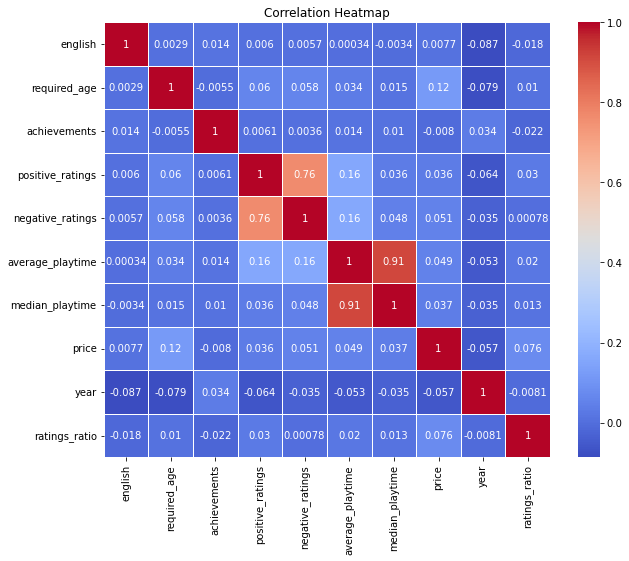

In [75]:
# Calculate the correlation matrix
correlation_matrix = steam.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Converting the categorical variables to dummy variables for regression

In [76]:
steam = steam.drop(columns=["release_date","median_playtime", "positive_ratings","negative_ratings"])

In [77]:
# Removing "Free to Play" tags from games that have nonzero price tags
steam.loc[(steam["price"] > 0) & (steam["genres"].str.contains("Free to Play")), "genres"] = steam["genres"].str.replace(r";?Free to Play", "", regex=True)

In [78]:
steam = pd.concat([steam, steam['platforms'].str.get_dummies(sep=';').add_prefix('platform_')], axis = 1).drop('platforms', 1)
steam = pd.concat([steam, steam['genres'].str.get_dummies(sep=';').add_prefix('genre_')], axis = 1).drop('genres', 1)
steam = pd.concat([steam, steam['categories'].str.get_dummies(sep=';').add_prefix('category_')], axis = 1).drop('categories', 1)
steam = pd.concat([steam, steam['owners'].str.get_dummies(sep=';').add_prefix('owners_')], axis = 1).drop('owners', 1)

In [79]:
steam = steam.dropna()

In [80]:
X = steam.drop(columns=["average_playtime"])
y = steam["average_playtime"]

In [81]:
#Standarizing numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
#Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Building Regression Models

In [93]:
#Ridge Regression
ridge_reg = Ridge(alpha=100)  
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

In [84]:
# Decision Tree Regression
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(y_test, tree_pred)
tree_r2 = r2_score(y_test, tree_pred)

In [101]:
# Random Forest Regression
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
forest_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_pred)
forest_rmse = np.sqrt(forest_mse)
forest_mae = mean_absolute_error(y_test, forest_pred)
forest_r2 = r2_score(y_test, forest_pred)

In [86]:
print("Metrics for Ridge Regression Model:")
print("Mean Squared Error:", ridge_mse)
print("Root Mean Squared Error:", ridge_rmse)
print("Mean Absolute Error:", ridge_mae)
print("R-squared:", ridge_r2)
print("---------------------------------------------------")
print("Metrics for Decision Tree Regression Model:")
print("Mean Squared Error:", tree_mse)
print("Root Mean Squared Error:", tree_rmse)
print("Mean Absolute Error:", tree_mae)
print("R-squared:", tree_r2)
print("---------------------------------------------------")
print("Metrics for Random Forest Regression Model:")
print("Mean Squared Error:", forest_mse)
print("Root Mean Squared Error:", forest_rmse)
print("Mean Absolute Error:", forest_mae)
print("R-squared:", forest_r2)
print("---------------------------------------------------")

Metrics for Ridge Regression Model:
Mean Squared Error: 10229278.998062266
Root Mean Squared Error: 3198.324404756695
Mean Absolute Error: 274.39839144061443
R-squared: 0.019010637795847884
---------------------------------------------------
Metrics for Decision Tree Regression Model:
Mean Squared Error: 14821056.638781164
Root Mean Squared Error: 3849.8125459275498
Mean Absolute Error: 302.66869806094184
R-squared: -0.4213415141012118
---------------------------------------------------
Metrics for Random Forest Regression Model:
Mean Squared Error: 10257024.509095624
Root Mean Squared Error: 3202.658974835695
Mean Absolute Error: 259.10741643582645
R-squared: 0.01634983920214461
---------------------------------------------------


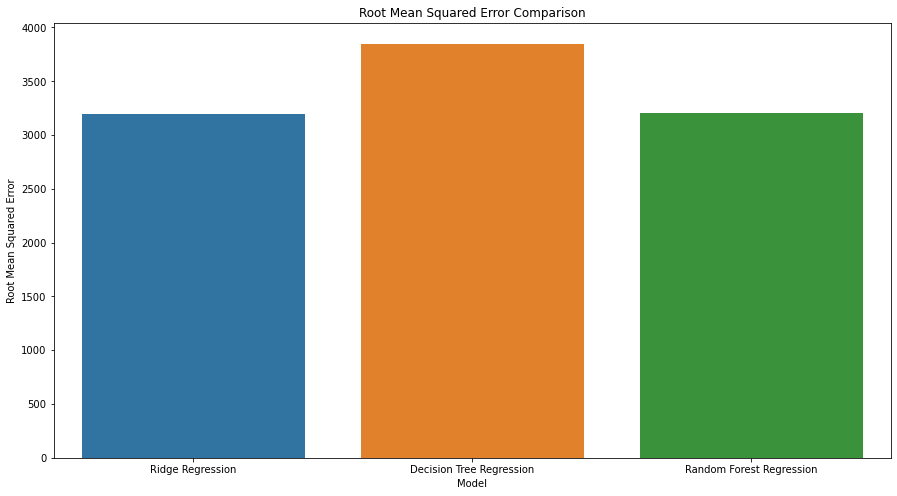

In [87]:
# Create a DataFrame for visualization
rmse_data = {
    "Model": ["Ridge Regression","Decision Tree Regression", "Random Forest Regression"],
    "RMSE": [ridge_rmse, tree_rmse, forest_rmse]
}
rmse_df = pd.DataFrame(rmse_data)

# Create a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x="Model", y="RMSE", data=rmse_df)
plt.title("Root Mean Squared Error Comparison")
plt.ylabel("Root Mean Squared Error")
plt.savefig("RMSE.png")
plt.show()

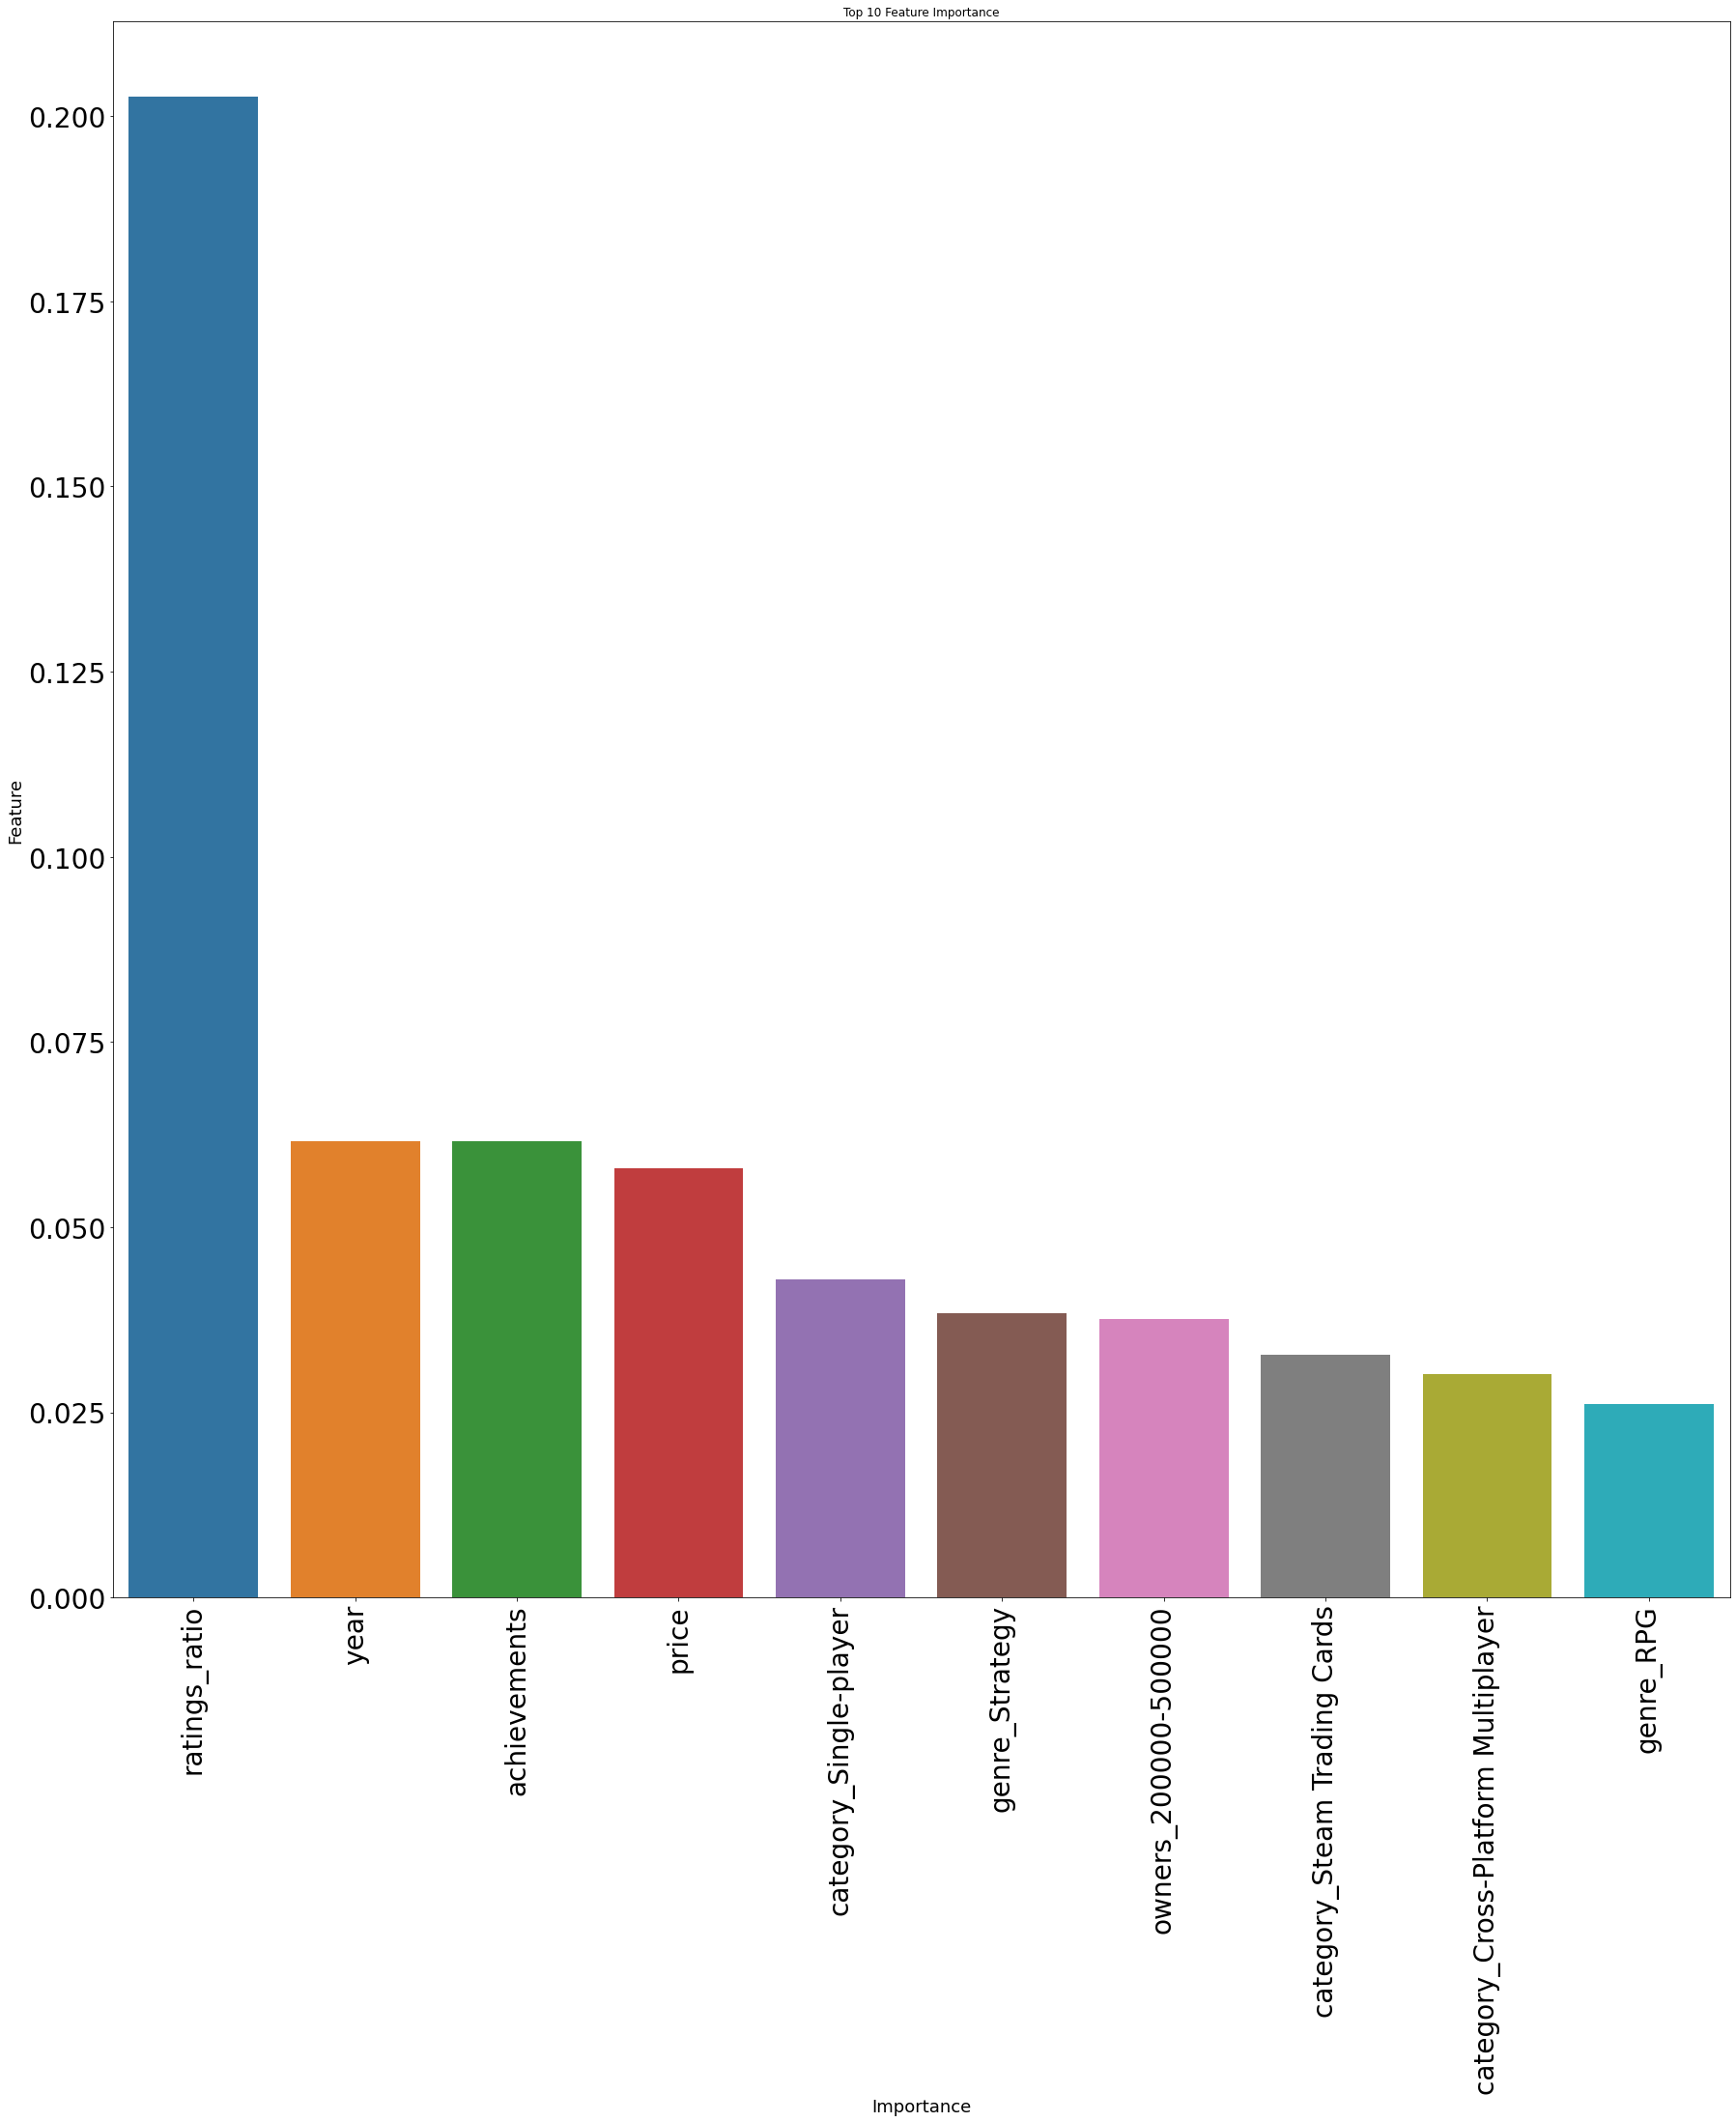

In [108]:
feature_importances = forest_reg.feature_importances_ 
feature_names = X.columns

# Creating a DataFrame for feature importances
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Sorting by importance and get the top 10 features
top_features = importance_df.nlargest(10, "Importance")

# Visualize the top 10 feature importances
plt.figure(figsize=(30, 30))
sns.barplot(x="Feature", y="Importance", data=top_features)
plt.title("Top 10 Feature Importance")
plt.xlabel("Importance", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.xticks(fontsize=28, rotation=90)
plt.yticks(fontsize=28)
plt.savefig("FeatureImportance.png")
plt.show()

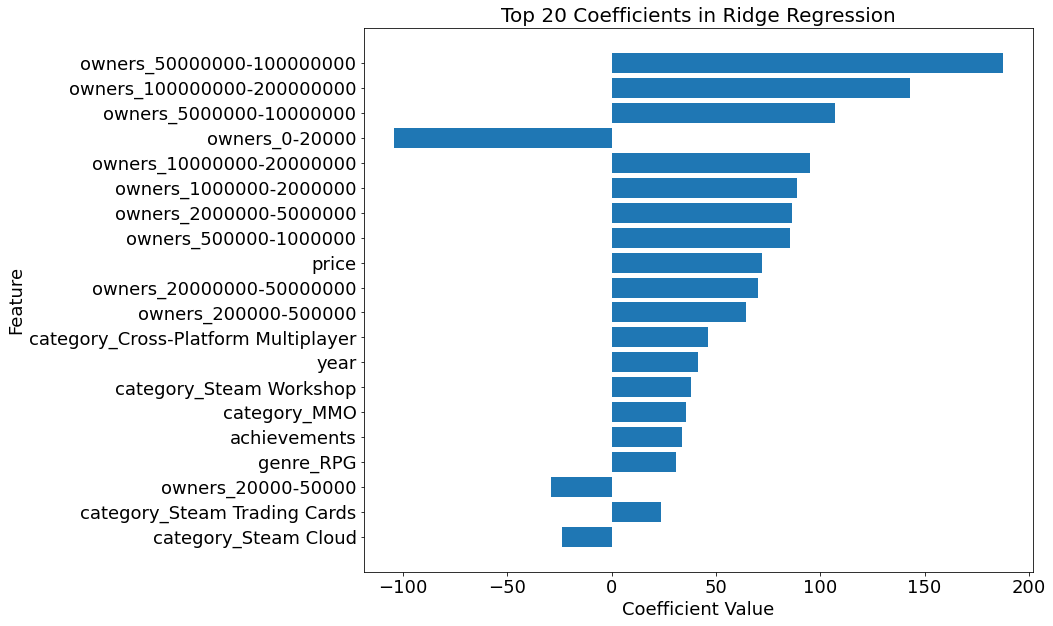

In [99]:
#Ridge Regression

coefficients = ridge_reg.coef_

# Create a DataFrame to show feature names and their corresponding coefficients
import pandas as pd
feature_importance_ridge = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values and get the top 20 coefficients
top_20_features = feature_importance_ridge.iloc[abs(feature_importance_ridge['Coefficient']).argsort()[-20:][::-1]]

# Plot the top 20 coefficients
plt.figure(figsize=(12, 10))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'])
plt.xlabel('Coefficient Value', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Top 20 Coefficients in Ridge Regression', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to have the largest coefficient at the top
plt.savefig("featureimportanceRidge.png")
plt.show()

### 10-fold Cross Validation

In [90]:
#ridge Regression
ridge_reg = Ridge(alpha=100)
ridge_scores = cross_val_score(ridge_reg, X_scaled, y, scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
print("ridge Regression Cross-Validation RMSE:", ridge_rmse_scores)

# Decision Tree Regression with Cross-Validation
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X_scaled, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print("Decision Tree Regression Cross-Validation RMSE:", tree_rmse_scores)

# Random Forest Regression with Cross-Validation
forest_reg = RandomForestRegressor(random_state=42)
forest_scores = cross_val_score(forest_reg, X_scaled, y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("Random Forest Regression Cross-Validation RMSE:", forest_rmse_scores)

ridge Regression Cross-Validation RMSE: [2512.91942759 1894.26499975 1974.58471844 3972.89755496  872.43981514
  933.38442711  573.71772931  227.01374687  873.08315778  218.13846163]
Decision Tree Regression Cross-Validation RMSE: [3598.80711691 3586.91053696 2393.44771425 5035.46694151 1526.71325295
 1068.14960285 1298.23946459 1457.98670324 1506.55030702  122.79830051]
Random Forest Regression Cross-Validation RMSE: [3155.68541738 1887.10733087 2085.50919634 4024.67266256 1068.8634732
 1100.54210977 1018.57855058  597.60890915  905.11678489  257.48811296]


In [91]:
#Cross-validation metrics
cv_rmse_ridge = np.mean(ridge_rmse_scores)
cv_rmse_tree = np.mean(tree_rmse_scores)
cv_rmse_forest = np.mean(forest_rmse_scores)
print("10-fold cross validation metric for ridge Regression:", cv_rmse_ridge)
print("10-fold cross validation metric for Decision Tree Regression:", cv_rmse_tree)
print("10-fold cross validation metric for Random Forest Regression:", cv_rmse_forest)

10-fold cross validation metric for ridge Regression: 1405.244403857909
10-fold cross validation metric for Decision Tree Regression: 2159.5069940782473
10-fold cross validation metric for Random Forest Regression: 1610.1172547692738
